# Simplified Detection Efficiency Model

Update to: V. C. Chmielewski and E. C. Bruning (2016), Lightning Mapping Array flash detection performance with variable receiver thresholds, J. Geophys. Res. Atmos., 121, 8600-8614, doi:10.1002/2016JD025159

Description: Instead of propogating random sources to the network, this calculates the minimum power that a given number of stations can sense at each grid point. These minimum powers are then related to the distribution of source powers as described in the paper above to estimate the detection efficincy.

Contact:
vanna.chmielewski@ttu.edu

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from mpl_toolkits.basemap import Basemap
from coordinateSystems import TangentPlaneCartesianSystem, GeographicSystem, MapProjection

In [3]:
c0 = 3.0e8 # m/s
dt_rms = 23.e-9 # seconds

sq = np.load('source_quantiles') # in Watts 
fde = 100-np.load('fde.csv') # Corresponding flash DE

Self-contained functions

In [4]:
def travel_time(X, X_ctr, c, t0=0.0, get_r=False):
    """ Units are meters, seconds.
        X is a (N,3) vector of source locations, and X_ctr is (N,3) receiver
        locations.

        t0 may be used to specify a fixed amount of additonal time to be
        added to the travel time.

        If get_r is True, return the travel time *and* calculated range.
        Otherwise
        just return the travel time.
    """
    ranges = (np.sum((X[:, np.newaxis] - X_ctr)**2, axis=2)**0.5).T
    time = t0+ranges/c
    if get_r == True:
        return time, ranges
    if get_r == False:
        return time

def min_power(threshold, r, wavelength=4.762, recv_gain=1.0):
    """ Calculate the free space loss. Defaults are for no receive gain and
        a 63 MHz wave.
        Units: watts, meters
    """
    four_pi_r = 4.0 * np.pi * r
    free_space_loss = (wavelength*wavelength) / (four_pi_r * four_pi_r)
    return threshold[:,np.newaxis] / (free_space_loss * recv_gain)

### Station coordinates and thresholds from a set of log files 
#### Specify: 
* start time 
* end time 
* the directory holding the log files 
* any stations you wish to exclude from the analysis

In [4]:
# import read_logs
# import os
# import datetime

# # start_time = datetime.datetime(2014,5,26,2) #25 set
# # end_time   = datetime.datetime(2014,5,26,3,50)
# useddir = '/Users/Vanna/Documents/logs/'
# exclude = np.array(['W','A',])

# days = np.array([start_time+datetime.timedelta(days=i) for i in range((end_time-start_time).days+1)])
# days_string = np.array([i.strftime("%y%m%d") for i in days])

# logs = pd.DataFrame()
# dir = os.listdir(useddir)
# for file in dir:
#     if np.any(file[2:] == days_string) & np.all(exclude!=file[1]): 
#         print file
#         logs = logs.combine_first(read_logs.parsing(useddir+file,T_set='True'))

# aves = logs[start_time:end_time].mean()
# aves = np.array(aves).reshape(4,len(aves)/4).T

### Station coordinates from csv file

Input network title and csv file here

In [5]:
Network = 'grid_LMA' # name of network in the csv file

stations = pd.read_csv('network.csv') # network csv file with one or multiple networks
stations.set_index('network').loc[Network]
aves = np.array(stations.set_index('network').loc[Network])[:,:-1].astype('float')

### Setting up and checking station locations

In [6]:
center = (np.mean(aves[:,1]), np.mean(aves[:,2]), np.mean(aves[:,0]))
geo  = GeographicSystem()
tanp = TangentPlaneCartesianSystem(center[0], center[1], center[2])
mapp = MapProjection
projl = MapProjection(projection='laea', lat_0=center[0], lon_0=center[1])

alt, lat, lon  = aves[:,:3].T
stations_ecef  = np.array(geo.toECEF(lon, lat, alt)).T
stations_local = tanp.toLocal(stations_ecef.T).T

center_ecef = np.array(geo.toECEF(center[1],center[0],center[2]))
ordered_threshs = aves[:,-1]

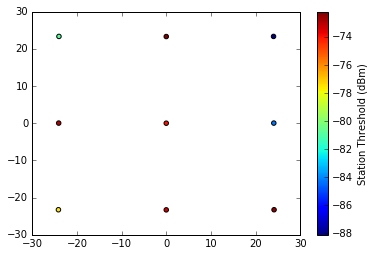

In [7]:
plt.scatter(stations_local[:,0]/1000., stations_local[:,1]/1000., c=aves[:,3])
plt.colorbar(label='Station Threshold (dBm)')
plt.show()

### Setting up grid

Input desired grid boundaries and interval here in meters from the center of the network. Uses initial grid in a map projection in order to have points with height AGL. Note that no points can be located directly over the center!

In [8]:
xmin, xmax, xint = -200001, 199999, 5000
ymin, ymax, yint = -200001, 199999, 5000
# alts = np.arange(500,20500,500.)
alts = np.array([7000])

initial_points = np.array(np.meshgrid(np.arange(xmin,xmax+xint,xint),
                                      np.arange(ymin,ymax+yint,yint), alts))

x,y,z=initial_points.reshape((3,np.size(initial_points)/3))
points2 = tanp.toLocal(np.array(projl.toECEF(x,y,z))).T

### Calculations at grid points
Set minimum station contribution here

Note: No current consideration for blockage from Earth curvature or difficult solutions which might result in poor performance due to station configuration

In [9]:
# tanp_all = []
# for i in range(len(aves[:,0])): 
#     tanp_all = tanp_all + [TangentPlaneCartesianSystem(aves[i,1],aves[i,2],aves[i,0])]

In [9]:
minimum_stations = 6

dt, ran  = travel_time(points2, stations_local, c=c0, get_r=True)
mins = min_power((10**(ordered_threshs/10.))*1e-3,ran)
req_power = np.partition(mins, minimum_stations-1,axis=0)[minimum_stations-1]

In [10]:
sde = np.zeros_like(req_power)
for i in range(len(sq[0])-1):
    selects = (req_power >= sq[1,i]) & (req_power < sq[1,i+1])
    sde[selects] = 100-sq[0,i+1]
    
selects = (req_power < sq[1,0]) 
sde[selects] = 100
sde = (sde.T.reshape(np.shape(initial_points[0,:,:,0])))

fde_a = np.empty_like(sde)
xs  = 1000./np.arange(10,1000,1.) # Theoretical source detection efficiency that corresponds with fde

selects = sde == 100. # Put into the next lowest or equivalent flash DE from given source DE
fde_a[selects] = 100.
for i in range(len(xs)-1):
    selects = (sde >= xs[1+i]) & (sde < xs[i])
    fde_a[selects] = fde[i]

### Plots

#### Detection efficiency

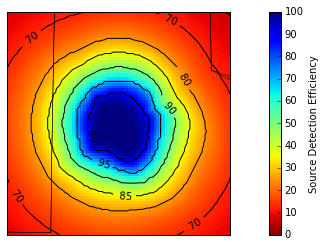

In [11]:
domain = 197.5*1000
maps = Basemap(projection='laea', lat_0=center[0], lon_0=center[1], width=domain*2, height=domain*2)
s = plt.pcolormesh(np.arange(xmin-xint/2.,xmax+3*xint/2.,xint)+domain,
                   np.arange(xmin-xint/2.,xmax+3*xint/2.,xint)+domain,
                   sde,
                  cmap = 'jet_r')
plt.colorbar(label='Source Detection Efficiency')
s.set_clim(vmin=0,vmax=100)
CS = plt.contour(np.arange(xmin,xmax+xint,xint)+domain,
                   np.arange(xmin,xmax+xint,xint)+domain,
                   fde_a, colors='k',levels=(20,40,60,70,80,85,90,95,99))
plt.clabel(CS, inline=1, fontsize=10,fmt='%3.0f')
plt.scatter(stations_local[:,0]+domain, stations_local[:,1]+domain, color='k',s=0.5)
maps.drawstates()

#### Minimum Detectable Source

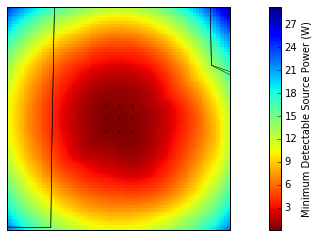

In [12]:
domain = 197.5*1000
maps = Basemap(projection='laea', lat_0=center[0], lon_0=center[1], width=domain*2, height=domain*2)
s = plt.pcolormesh(np.arange(xmin-xint/2.,xmax+3*xint/2.,xint)+domain,
                   np.arange(xmin-xint/2.,xmax+3*xint/2.,xint)+domain,
                   req_power.T.reshape(np.shape(initial_points[0,:,:,0])),
                  cmap = 'jet_r')
plt.colorbar(label='Minimum Detectable Source Power (W)')
plt.scatter(stations_local[:,0]+domain, stations_local[:,1]+domain, color='k',s=0.5)
maps.drawstates()
